In [1]:
import respiratory_extraction.dataset as repository

dataset = repository.from_default()

subject = 'Proband16'
scenario = '101_natural_lighting'

subject_frames, params = dataset.read_video_gray(subject, scenario)

Reading video:   0%|          | 0/3600 [00:00<?, ?it/s]

In [2]:
hyperparameters = {
    'OFP_maxCorners': 100,
    'OFP_qualityLevel': 0.1,
    'OFP_minDistance': 7,
    'OFP_mask': None,
    'OFP_QualityLevelRV': 0.05,
    'OFP_winSize': (15, 15),
    'OFP_maxLevel': 2,
    'FSS_maxCorners': 100,
    'FSS_qualityLevel': 0.1,
    'FSS_minDistance': 7,
    'FSS_mask': None,
    'FSS_QualityLevelRV': 0.05,
    'FSS_FPN': 5,
    'Filter_order': 3,
    'Filter_LowPass': 0.1,
    'Filter_HighPass': 0.6,
    'RR_Algorithm_PC_Height': None,
    'RR_Algorithm_PC_Threshold': None,
    'RR_Algorithm_PC_MaxRR': 45,
    'RR_Algorithm_NFCP_qualityLevel': 0.6
}

In [3]:
import numpy as np
import respiratory_extraction.utils as utils
import respiratory_extraction.models.optical_flow as optical_flow


def find_roi(frame: np.ndarray) -> tuple[int, int, int, int]:
    """
    Find the region of interest (ROI) based on the face detection
    :param frame: The frame to find the ROI
    :return: The region of interest (ROI) coordinates (x, y, w, h)
    """

    faces = utils.detect_faces(frame)

    if len(faces) == 0:
        raise ValueError('No face detected in the first frame')
    elif len(faces) > 1:
        raise ValueError('Multiple faces detected in the first frame')

    return utils.roi_from_face(faces[0], scale_w=0.2, scale_h=0.2)

In [4]:
frame1 = subject_frames[0]
subject_roi = find_roi(frame1)
subject_roi_mask = utils.roi_to_mask(frame1, subject_roi)

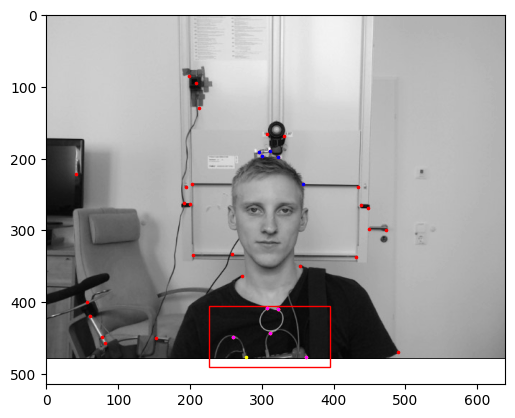

In [5]:
import matplotlib.pyplot as plt

# Get different feature points for the first frame
default_points = optical_flow.get_feature_points(frame1)
special_points = optical_flow.get_feature_points(frame1, fpn=5)
roi_points = optical_flow.get_feature_points(frame1, roi_mask=subject_roi_mask)
special_roi = optical_flow.get_feature_points(frame1, roi_mask=subject_roi_mask, fpn=5)

# Plot the first frame with the feature points
plt.imshow(frame1, cmap='gray')

# Draw the region of interest (ROI)
roi_x, roi_y, roi_w, roi_h = subject_roi
plt.gca().add_patch(plt.Rectangle(
    (roi_x, roi_y), roi_w, roi_h,
    linewidth=1, edgecolor='r', facecolor='none'))

for iny in range(default_points.shape[0]):
    plt.scatter(default_points[iny, 0, 0],
                default_points[iny, 0, 1],
                c='r', s=2.5)

for iny in range(special_points.shape[0]):
    plt.scatter(special_points[iny, 0, 0],
                special_points[iny, 0, 1],
                c='b', s=2.5)

for iny in range(roi_points.shape[0]):
    plt.scatter(roi_points[iny, 0, 0],
                roi_points[iny, 0, 1],
                c='#FFFF00', s=2.5)

for iny in range(special_roi.shape[0]):
    plt.scatter(special_roi[iny, 0, 0],
                special_roi[iny, 0, 1],
                c='#FF00FF', s=2.5)

plt.show()

In [6]:
raw_signal = optical_flow.extract_raw_signal(
    subject_frames,
    fpn=5,
    quality_level=hyperparameters['OFP_qualityLevel'],
    quality_level_rv=hyperparameters['OFP_QualityLevelRV'],
)

In [7]:
preprocessed_unprocessed = optical_flow.preprocess_signal(
    raw_signal,
    params.fps,
    lowpass=hyperparameters['Filter_LowPass'],
    highpass=hyperparameters['Filter_HighPass'],
)

signal_cgof = optical_flow.preprocess_signal(
    raw_signal,
    params.fps,
    lowpass=hyperparameters['Filter_LowPass'],
    highpass=hyperparameters['Filter_HighPass'],
    use_cgof=True,
)
signal_filter = optical_flow.preprocess_signal(
    raw_signal,
    params.fps,
    lowpass=hyperparameters['Filter_LowPass'],
    highpass=hyperparameters['Filter_HighPass'],
    use_cgof=True,
    use_filter=True,
)
signal_normalization = optical_flow.preprocess_signal(
    raw_signal,
    params.fps,
    lowpass=hyperparameters['Filter_LowPass'],
    highpass=hyperparameters['Filter_HighPass'],
    use_cgof=True,
    use_filter=True,
    use_normalization=True,
)

processed_signal = signal_normalization

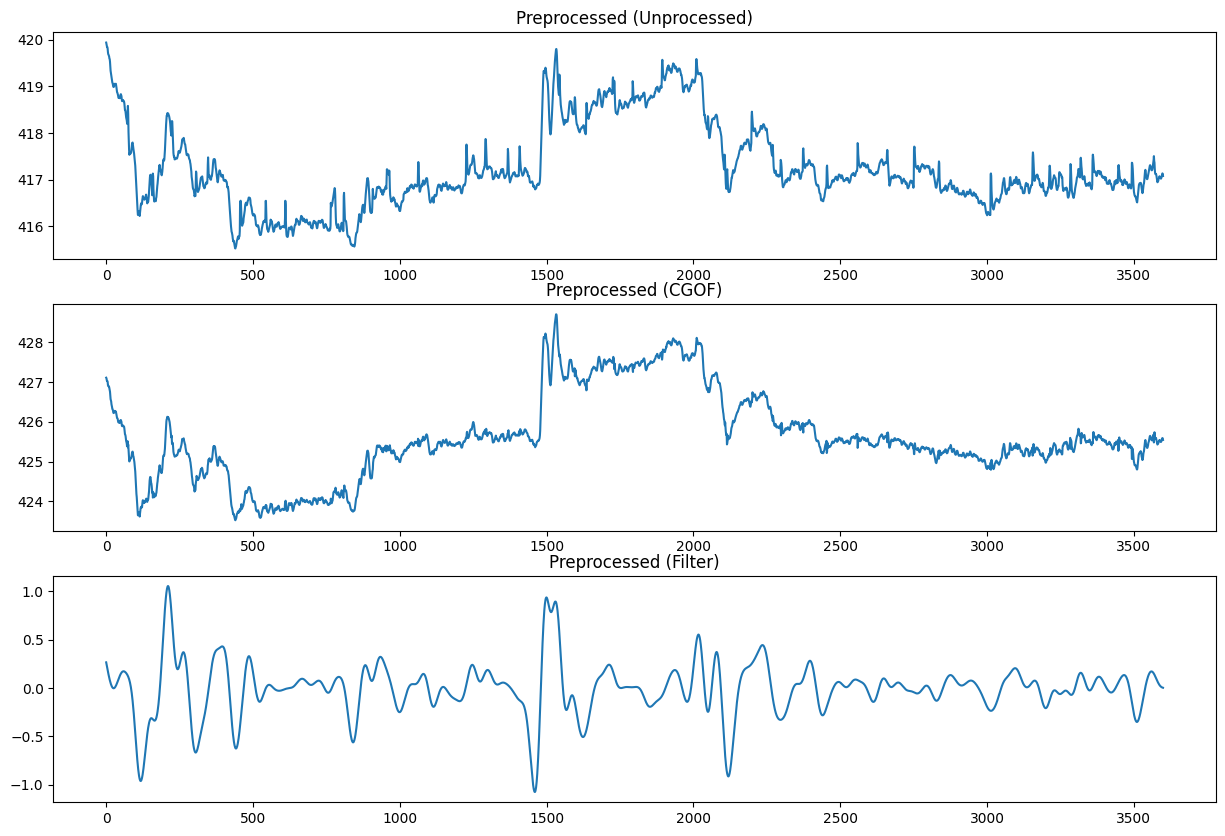

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(15, 10))

axs[0].plot(preprocessed_unprocessed)
axs[0].set_title('Preprocessed (Unprocessed)')

axs[1].plot(signal_cgof)
axs[1].set_title('Preprocessed (CGOF)')

axs[2].plot(signal_filter)
axs[2].set_title('Preprocessed (Filter)')

plt.show()

In [16]:
from scipy import signal

gt_signal, gt_fps = dataset.get_ground_truth_rr_signal(subject, scenario)

# Normalize the ground truth signal between 0.5 and -0.5
gt_signal = (gt_signal - np.min(gt_signal)) / (np.max(gt_signal) - np.min(gt_signal)) - 0.5

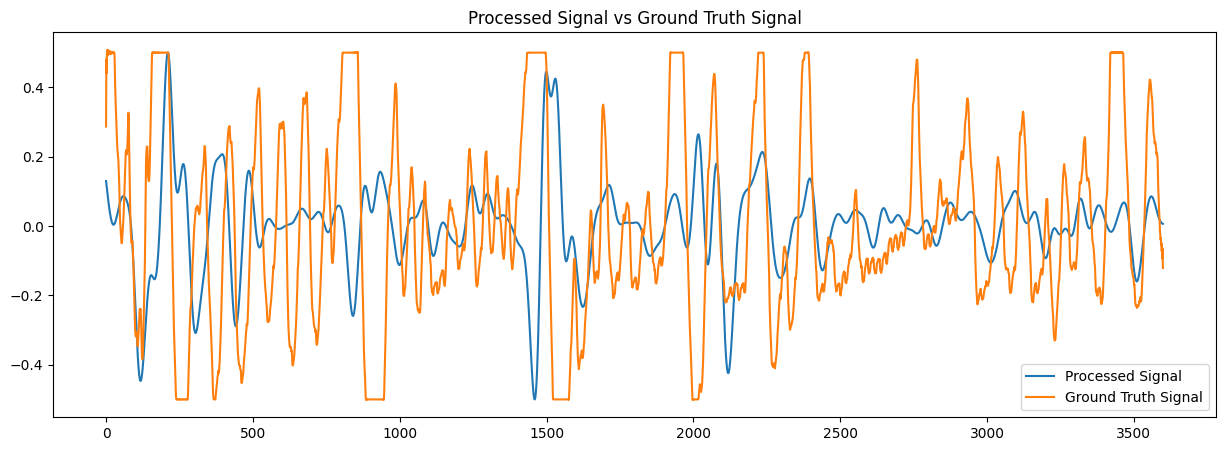

In [17]:
# Plot the processed_signal and the gt_signal in the same plot without subplots
plt.figure(figsize=(15, 5))
plt.title('Processed Signal vs Ground Truth Signal')

plt.plot(processed_signal, label='Processed Signal')

# Downsample the ground truth signal to the same FPS
gt_signal_down = signal.resample(gt_signal, len(processed_signal))
plt.plot(gt_signal_down, label='Ground Truth Signal')

plt.legend()
plt.show()

In [18]:
get_ground_truth_rr = dataset.get_ground_truth_rr(subject, scenario)
get_ground_truth_rr, get_ground_truth_rr * 60

(0.1869918699186992, 11.219512195121952)

In [19]:
# Calculate the frequencies using the different methods for the ground truth signal
frequency = optical_flow.FrequencyExtraction(gt_signal, gt_fps)

gt_frequency = {
    'FFT': frequency.fft(),
    'PC': frequency.peak_counting(),
    'CP': frequency.crossing_point(),
    'NFCP': frequency.negative_feedback_crossover_point_method()
}
gt_frequency

{'FFT': 0.04065557108372506,
 'PC': 0.4796747967479675,
 'CP': 3.2845528455284554,
 'NFCP': 3.2845528455284554}

In [20]:
import pandas as pd

evaluation_results = []

for fpn in [None, 5]:
    for use_roi in [False, True]:
        if use_roi:
            roi_mask = subject_roi_mask
        else:
            roi_mask = None

        raw_signal = optical_flow.extract_raw_signal(
            subject_frames,
            fpn=fpn,
            quality_level=0.3,
            quality_level_rv=0.05,
            roi_mask=roi_mask,
        )

        breathing_signal = optical_flow.preprocess_signal(
            raw_signal,
            params.fps,
            use_cgof=True,
            use_filter=True,
            use_normalization=True,
        )

        frequency = optical_flow.FrequencyExtraction(breathing_signal, params.fps)

        predictions = {
            'FFT': frequency.fft(),
            'PC': frequency.peak_counting(),
            'CP': frequency.crossing_point(),
            'NFCP': frequency.negative_feedback_crossover_point_method(),
        }

        for method, value in predictions.items():
            evaluation_results.append({
                'fpn': fpn if fpn is not None else 'None',
                'use_roi': use_roi,
                'method': method,
                'value': value,
                'error': abs(value - gt_frequency[method]),
            })

In [21]:
evaluation = pd.DataFrame(evaluation_results)
evaluation

,fpn,use_roi,method,value,error
0,None,False,FFT,0.183384,0.142729
1,None,False,PC,0.308333,0.171341
2,None,False,CP,0.312500,2.972053
3,None,False,NFCP,0.312500,2.972053
4,None,True,FFT,0.133370,0.092715
5,None,True,PC,0.316667,0.163008
6,None,True,CP,0.320833,2.963720
7,None,True,NFCP,0.320833,2.963720
8,5,False,FFT,0.166713,0.126057
9,5,False,PC,0.350000,0.129675


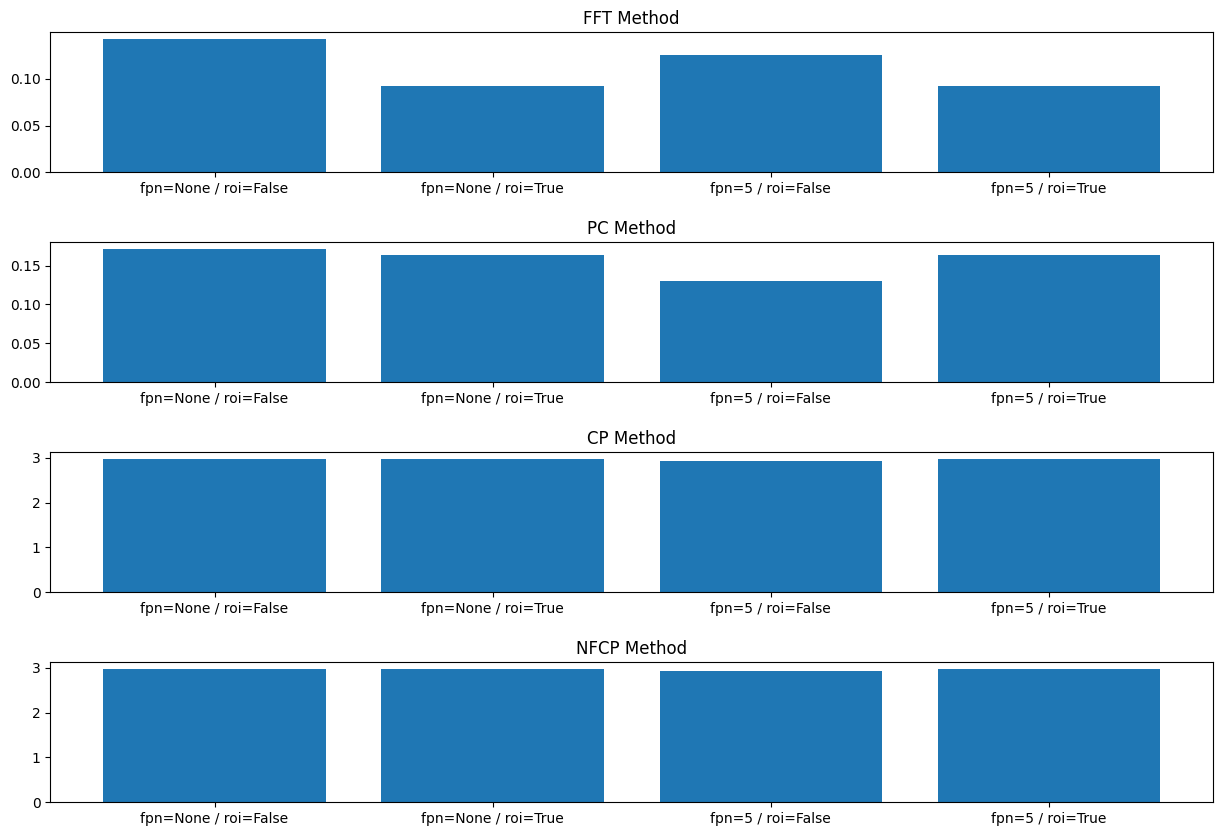

In [22]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

# Add more space between the subplots
fig.subplots_adjust(hspace=0.5)

inx = 0
for method in gt_frequency.keys():
    axs[inx].set_title(f'{method} Method')

    # Plot the values for each method
    data = evaluation[evaluation['method'] == method]

    title = 'fpn=' + data['fpn'].astype(str) + ' / roi=' + data['use_roi'].astype(str)
    axs[inx].bar(title, data['error'])

    inx += 1